Demo 03: Validación y Calidad de Datos
=======================================
Esta demostración muestra cómo validar la calidad de datos de mantenimiento
y generar reportes de calidad para la industria petrolera.

In [ ]:
%pip install pandas numpy matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import re

print("=" * 60)
print("DEMO 03: VALIDACIÓN Y CALIDAD DE DATOS")
print("=" * 60)

DEMO 03: VALIDACIÓN Y CALIDAD DE DATOS


Cargar datos

In [2]:
# Cargar datos
print("\n1. CARGANDO DATOS DE MANTENIMIENTO")
print("-" * 40)
df = pd.read_csv('/workspaces/CursoPython-Basico-JuanDavid/Sesión_14/datos/mantenimiento.csv')
print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Columnas: {list(df.columns)}")


1. CARGANDO DATOS DE MANTENIMIENTO
----------------------------------------
Dataset cargado: 205 filas, 9 columnas
Columnas: ['id_mantenimiento', 'fecha', 'equipo', 'tipo_mantenimiento', 'horas_trabajo', 'costo_usd', 'tecnico_responsable', 'descripcion', 'pozo_id']


Exploración inicial

In [4]:
# Exploración inicial
print("\n2. EXPLORACIÓN INICIAL")
print("-" * 40)
print("\nPrimeras 5 filas:")
print(df.head())

print("\nTipos de datos:")
print(df.dtypes)


2. EXPLORACIÓN INICIAL
----------------------------------------

Primeras 5 filas:
  id_mantenimiento       fecha     equipo tipo_mantenimiento  horas_trabajo  \
0         MNT-0061  2024-09-03      Bomba         Correctivo           48.0   
1         MNT-0133  2024-08-08    Válvula         Emergencia            5.4   
2         MNT-0007  2024-01-01      Bomba         Correctivo            5.2   
3         MNT-0016  2024-11-09  Compresor         preventivo            1.3   
4         MNT-0103  2024-03-22  Separador         Correctivo            5.6   

   costo_usd tecnico_responsable                         descripcion   pozo_id  
0    3109.16        Ana Martinez  Mantenimiento rutinario del equipo  POZO-001  
1    3628.38        Ana Martinez  Mantenimiento rutinario del equipo  POZO-001  
2     486.36        Ana Martinez  Mantenimiento rutinario del equipo  POZO-003  
3     399.50        Carlos Lopez  Mantenimiento rutinario del equipo  POZO-002  
4    2636.48        Carlos Lopez  Ma

funciones

In [5]:

# Funciones de validación
def validar_completitud(df):
    """
    Valida qué tan completos están los datos
    """
    total_celdas = df.shape[0] * df.shape[1]
    celdas_faltantes = df.isnull().sum().sum()
    completitud = (1 - celdas_faltantes / total_celdas) * 100
    
    reporte = {
        'total_celdas': total_celdas,
        'celdas_faltantes': celdas_faltantes,
        'completitud_porcentaje': completitud,
        'columnas_incompletas': {}
    }
    
    for col in df.columns:
        faltantes = df[col].isnull().sum()
        if faltantes > 0:
            reporte['columnas_incompletas'][col] = {
                'faltantes': faltantes,
                'porcentaje': (faltantes / len(df)) * 100
            }
    
    return reporte

In [7]:
def validar_unicidad(df, columna_id='id_mantenimiento'):
    """
    Valida duplicados en el dataset
    """
    duplicados_totales = df.duplicated().sum()
    duplicados_id = df[columna_id].duplicated().sum()
    
    reporte = {
        'registros_duplicados': duplicados_totales,
        'ids_duplicados': duplicados_id,
        'registros_unicos': len(df) - duplicados_totales
    }
    
    if duplicados_id > 0:
        reporte['ejemplos_duplicados'] = df[df[columna_id].duplicated(keep=False)][columna_id].head(10).tolist()
    
    return reporte

In [9]:
def validar_consistencia(df):
    """
    Valida la consistencia de los datos
    """
    inconsistencias = []
    
    # Convertir fecha a datetime para validaciones
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
    
    # Fechas futuras
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df[df['fecha'] > fecha_actual]
    if len(fechas_futuras) > 0:
        inconsistencias.append({
            'tipo': 'Fechas futuras',
            'cantidad': len(fechas_futuras),
            'ejemplos': fechas_futuras[['id_mantenimiento', 'fecha']].head(3).to_dict('records')
        })
    
    # Horas de trabajo negativas o excesivas
    horas_invalidas = df[(df['horas_trabajo'] < 0) | (df['horas_trabajo'] > 24)]
    if len(horas_invalidas) > 0:
        inconsistencias.append({
            'tipo': 'Horas de trabajo inválidas',
            'cantidad': len(horas_invalidas),
            'ejemplos': horas_invalidas[['id_mantenimiento', 'horas_trabajo']].head(3).to_dict('records')
        })
    
    # Costos negativos
    costos_negativos = df[df['costo_usd'] < 0]
    if len(costos_negativos) > 0:
        inconsistencias.append({
            'tipo': 'Costos negativos',
            'cantidad': len(costos_negativos),
            'ejemplos': costos_negativos[['id_mantenimiento', 'costo_usd']].head(3).to_dict('records')
        })
    
    # Inconsistencias en formato de texto
    tipos_mantenimiento_esperados = ['Preventivo', 'Correctivo', 'Predictivo', 'Emergencia']
    tipos_inconsistentes = df[~df['tipo_mantenimiento'].isin(tipos_mantenimiento_esperados)]
    if len(tipos_inconsistentes) > 0:
        inconsistencias.append({
            'tipo': 'Tipos de mantenimiento no estandarizados',
            'cantidad': len(tipos_inconsistentes),
            'valores_unicos': tipos_inconsistentes['tipo_mantenimiento'].unique().tolist()
        })
    
    return inconsistencias

In [10]:
def validar_rangos(df):
    """
    Valida que los valores estén dentro de rangos esperados
    """
    validaciones = []
    
    # Rangos esperados para la industria
    rangos = {
        'horas_trabajo': (0, 24),
        'costo_usd': (0, 10000)
    }
    
    for columna, (min_val, max_val) in rangos.items():
        fuera_rango = df[(df[columna] < min_val) | (df[columna] > max_val)]
        if len(fuera_rango) > 0:
            validaciones.append({
                'columna': columna,
                'rango_esperado': f"[{min_val}, {max_val}]",
                'valores_fuera': len(fuera_rango),
                'porcentaje': (len(fuera_rango) / len(df)) * 100
            })
    
    return validaciones

 VALIDACIÓN DE COMPLETITUD

In [11]:
print("\n3. VALIDACIÓN DE COMPLETITUD")
print("-" * 40)
reporte_completitud = validar_completitud(df)
print(f"Completitud general: {reporte_completitud['completitud_porcentaje']:.2f}%")
print(f"Celdas faltantes: {reporte_completitud['celdas_faltantes']} de {reporte_completitud['total_celdas']}")

if reporte_completitud['columnas_incompletas']:
    print("\nColumnas con valores faltantes:")
    for col, info in reporte_completitud['columnas_incompletas'].items():
        print(f"  {col}: {info['faltantes']} valores ({info['porcentaje']:.1f}%)")


3. VALIDACIÓN DE COMPLETITUD
----------------------------------------
Completitud general: 99.19%
Celdas faltantes: 15 de 1845

Columnas con valores faltantes:
  costo_usd: 5 valores (2.4%)
  descripcion: 10 valores (4.9%)


VALIDACIÓN DE UNICIDAD

In [12]:
print("\n4. VALIDACIÓN DE UNICIDAD")
print("-" * 40)
reporte_unicidad = validar_unicidad(df)
print(f"Registros duplicados: {reporte_unicidad['registros_duplicados']}")
print(f"IDs duplicados: {reporte_unicidad['ids_duplicados']}")
if 'ejemplos_duplicados' in reporte_unicidad:
    print(f"Ejemplos de IDs duplicados: {reporte_unicidad['ejemplos_duplicados'][:5]}")


4. VALIDACIÓN DE UNICIDAD
----------------------------------------
Registros duplicados: 5
IDs duplicados: 5
Ejemplos de IDs duplicados: ['MNT-0136', 'MNT-0129', 'MNT-0129', 'MNT-0091', 'MNT-0168']


VALIDACIÓN DE CONSISTENCIA

In [14]:
print("\n5. VALIDACIÓN DE CONSISTENCIA")
print("-" * 40)
inconsistencias = validar_consistencia(df)
if inconsistencias:
    for inc in inconsistencias:
        print(f"\n{inc['tipo']}:")
        print(f"  Cantidad: {inc['cantidad']}")
        if 'ejemplos' in inc:
            print(f"  Ejemplos: {inc['ejemplos'][:2]}")
        if 'valores_unicos' in inc:
            print(f"  Valores encontrados: {inc['valores_unicos']}")
else:
    print("No se encontraron inconsistencias")


5. VALIDACIÓN DE CONSISTENCIA
----------------------------------------

Horas de trabajo inválidas:
  Cantidad: 2
  Ejemplos: [{'id_mantenimiento': 'MNT-0061', 'horas_trabajo': 48.0}, {'id_mantenimiento': 'MNT-0051', 'horas_trabajo': -3.0}]

Costos negativos:
  Cantidad: 1
  Ejemplos: [{'id_mantenimiento': 'MNT-0052', 'costo_usd': -500.0}]

Tipos de mantenimiento no estandarizados:
  Cantidad: 3
  Valores encontrados: ['preventivo', 'CORRECTIVO', 'Pred.']


VALIDACIÓN DE RANGOS

In [15]:
print("\n6. VALIDACIÓN DE RANGOS")
print("-" * 40)
validaciones_rango = validar_rangos(df)
if validaciones_rango:
    for val in validaciones_rango:
        print(f"\n{val['columna']}:")
        print(f"  Rango esperado: {val['rango_esperado']}")
        print(f"  Valores fuera de rango: {val['valores_fuera']} ({val['porcentaje']:.1f}%)")
else:
    print("Todos los valores están dentro de los rangos esperados")


6. VALIDACIÓN DE RANGOS
----------------------------------------

horas_trabajo:
  Rango esperado: [0, 24]
  Valores fuera de rango: 2 (1.0%)

costo_usd:
  Rango esperado: [0, 10000]
  Valores fuera de rango: 2 (1.0%)


Limpieza y corrección de datos

In [17]:
# Limpieza y corrección de datos
print("\n7. LIMPIEZA Y CORRECCIÓN DE DATOS")
print("-" * 40)

df_limpio = df.copy()


7. LIMPIEZA Y CORRECCIÓN DE DATOS
----------------------------------------


In [18]:
# Eliminar duplicados
print("\nEliminando duplicados...")
inicial = len(df_limpio)
df_limpio = df_limpio.drop_duplicates(subset=['id_mantenimiento'], keep='first')
print(f"  Registros eliminados: {inicial - len(df_limpio)}")


Eliminando duplicados...
  Registros eliminados: 5


In [19]:
# Estandarizar tipos de mantenimiento
print("\nEstandarizando tipos de mantenimiento...")
mapeo_tipos = {
    'preventivo': 'Preventivo',
    'PREVENTIVO': 'Preventivo',
    'correctivo': 'Correctivo',
    'CORRECTIVO': 'Correctivo',
    'Pred.': 'Predictivo',
    'predictivo': 'Predictivo'
}

tipos_antes = df_limpio['tipo_mantenimiento'].unique()
df_limpio['tipo_mantenimiento'] = df_limpio['tipo_mantenimiento'].replace(mapeo_tipos)
tipos_despues = df_limpio['tipo_mantenimiento'].unique()
print(f"  Tipos antes: {len(tipos_antes)}")
print(f"  Tipos después: {len(tipos_despues)}")


Estandarizando tipos de mantenimiento...
  Tipos antes: 7
  Tipos después: 4


In [20]:
# Estandarizar nombres de técnicos
print("\nEstandarizando nombres de técnicos...")
def estandarizar_nombre(nombre):
    if pd.isna(nombre):
        return nombre
    # Eliminar espacios extras
    nombre = re.sub(r'\s+', ' ', nombre.strip())
    # Capitalizar correctamente
    return nombre.title()

df_limpio['tecnico_responsable'] = df_limpio['tecnico_responsable'].apply(estandarizar_nombre)


Estandarizando nombres de técnicos...


In [21]:
# Corregir valores inválidos
print("\nCorrigiendo valores inválidos...")
# Horas negativas -> valor absoluto
df_limpio.loc[df_limpio['horas_trabajo'] < 0, 'horas_trabajo'] = abs(df_limpio.loc[df_limpio['horas_trabajo'] < 0, 'horas_trabajo'])
# Costos negativos -> valor absoluto
df_limpio.loc[df_limpio['costo_usd'] < 0, 'costo_usd'] = abs(df_limpio.loc[df_limpio['costo_usd'] < 0, 'costo_usd'])
# Fechas futuras -> fecha actual
fecha_actual = pd.Timestamp.now()
df_limpio.loc[df_limpio['fecha'] > fecha_actual, 'fecha'] = fecha_actual


Corrigiendo valores inválidos...


In [22]:
# Imputar valores faltantes
print("\nImputando valores faltantes...")
# Descripción faltante -> texto genérico
df_limpio['descripcion'].fillna('Mantenimiento rutinario - sin descripción detallada', inplace=True)
# Costo faltante -> mediana por tipo de mantenimiento
df_limpio['costo_usd'] = df_limpio.groupby('tipo_mantenimiento')['costo_usd'].transform(
    lambda x: x.fillna(x.median())
)


Imputando valores faltantes...


/tmp/ipykernel_29063/2023904055.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpio['descripcion'].fillna('Mantenimiento rutinario - sin descripción detallada', inplace=True)


REPORTE DE CALIDAD FINAL

In [23]:
# Generar reporte de calidad final
print("\n8. REPORTE DE CALIDAD FINAL")
print("-" * 40)

def generar_reporte_calidad(df_original, df_limpio):
    """
    Genera un reporte completo de calidad de datos
    """
    reporte = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset': 'mantenimiento.csv',
        'metricas_originales': {
            'registros': len(df_original),
            'columnas': len(df_original.columns),
            'completitud': validar_completitud(df_original)['completitud_porcentaje'],
            'duplicados': validar_unicidad(df_original)['registros_duplicados']
        },
        'metricas_limpias': {
            'registros': len(df_limpio),
            'columnas': len(df_limpio.columns),
            'completitud': validar_completitud(df_limpio)['completitud_porcentaje'],
            'duplicados': validar_unicidad(df_limpio)['registros_duplicados']
        },
        'mejoras': {
            'registros_eliminados': len(df_original) - len(df_limpio),
            'mejora_completitud': validar_completitud(df_limpio)['completitud_porcentaje'] - 
                                 validar_completitud(df_original)['completitud_porcentaje']
        }
    }
    
    return reporte

reporte_final = generar_reporte_calidad(df, df_limpio)


8. REPORTE DE CALIDAD FINAL
----------------------------------------


In [24]:
print("\nREPORTE DE CALIDAD DE DATOS")
print("=" * 50)
print(f"Fecha: {reporte_final['timestamp']}")
print(f"Dataset: {reporte_final['dataset']}")
print("\nMÉTRICAS ORIGINALES:")
for key, value in reporte_final['metricas_originales'].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")
print("\nMÉTRICAS DESPUÉS DE LIMPIEZA:")
for key, value in reporte_final['metricas_limpias'].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")
print("\nMEJORAS:")
print(f"  Registros eliminados: {reporte_final['mejoras']['registros_eliminados']}")
print(f"  Mejora en completitud: {reporte_final['mejoras']['mejora_completitud']:.2f}%")



REPORTE DE CALIDAD DE DATOS
Fecha: 2025-08-13 21:35:47
Dataset: mantenimiento.csv

MÉTRICAS ORIGINALES:
  registros: 205
  columnas: 9
  completitud: 99.19
  duplicados: 5

MÉTRICAS DESPUÉS DE LIMPIEZA:
  registros: 200
  columnas: 9
  completitud: 100.00
  duplicados: 0

MEJORAS:
  Registros eliminados: 5
  Mejora en completitud: 0.81%


Visualización del proceso de limpieza


9. VISUALIZACIÓN DE RESULTADOS
----------------------------------------
Gráfico guardado como 'reporte_calidad.png'


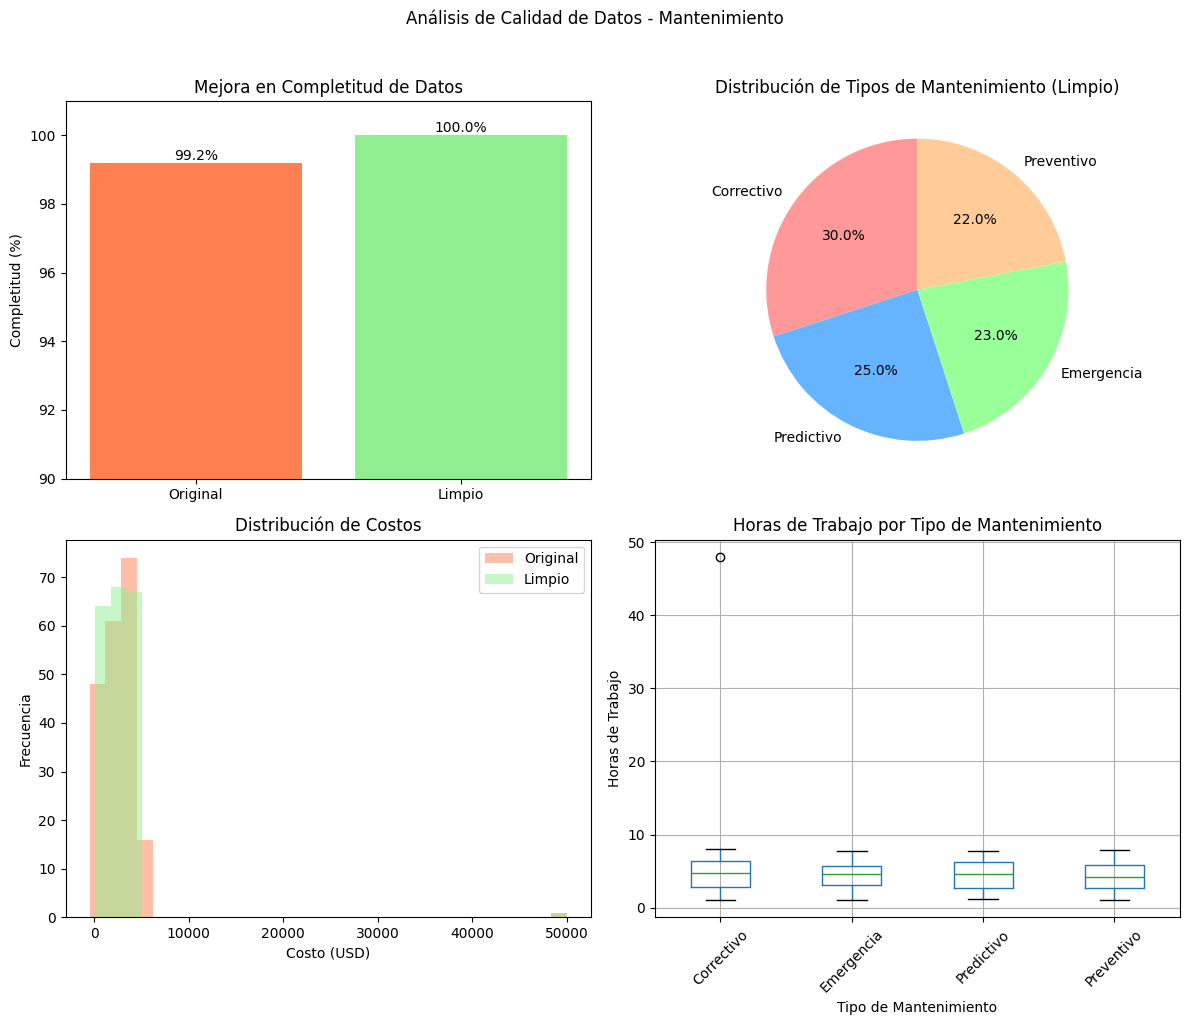

In [25]:
# Visualización del proceso de limpieza
print("\n9. VISUALIZACIÓN DE RESULTADOS")
print("-" * 40)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Completitud antes y después
ax1 = axes[0, 0]
categorias = ['Original', 'Limpio']
completitud = [
    reporte_final['metricas_originales']['completitud'],
    reporte_final['metricas_limpias']['completitud']
]
bars = ax1.bar(categorias, completitud, color=['coral', 'lightgreen'])
ax1.set_ylabel('Completitud (%)')
ax1.set_title('Mejora en Completitud de Datos')
ax1.set_ylim([90, 101])
for bar, val in zip(bars, completitud):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{val:.1f}%', ha='center')

# Distribución de tipos de mantenimiento
ax2 = axes[0, 1]
tipos_counts = df_limpio['tipo_mantenimiento'].value_counts()
ax2.pie(tipos_counts.values, labels=tipos_counts.index, autopct='%1.1f%%',
        startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
ax2.set_title('Distribución de Tipos de Mantenimiento (Limpio)')

# Histograma de costos
ax3 = axes[1, 0]
ax3.hist(df['costo_usd'].dropna(), bins=30, alpha=0.5, label='Original', color='coral')
ax3.hist(df_limpio['costo_usd'].dropna(), bins=30, alpha=0.5, label='Limpio', color='lightgreen')
ax3.set_xlabel('Costo (USD)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de Costos')
ax3.legend()

# Horas de trabajo por tipo
ax4 = axes[1, 1]
df_limpio.boxplot(column='horas_trabajo', by='tipo_mantenimiento', ax=ax4)
ax4.set_xlabel('Tipo de Mantenimiento')
ax4.set_ylabel('Horas de Trabajo')
ax4.set_title('Horas de Trabajo por Tipo de Mantenimiento')
plt.sca(ax4)
plt.xticks(rotation=45)

plt.suptitle('Análisis de Calidad de Datos - Mantenimiento', y=1.02)
plt.tight_layout()
plt.savefig('reporte_calidad.png')
print("Gráfico guardado como 'reporte_calidad.png'")

Guardar datos limpios

In [26]:
# Guardar datos limpios
df_limpio.to_csv('/workspaces/CursoPython-Basico-JuanDavid/Sesión_14/datos/mantenimiento_limpio.csv', index=False)
print("\nDataset limpio guardado como 'mantenimiento_limpio.csv'")


Dataset limpio guardado como 'mantenimiento_limpio.csv'


Guardar reporte en JSON

In [28]:
# Guardar reporte en JSON
import json
with open('/workspaces/CursoPython-Basico-JuanDavid/Sesión_14/datos/reporte_calidad.json', 'w') as f:
    json.dump(reporte_final, f, indent=2, default=str)
print("Reporte de calidad guardado como 'reporte_calidad.json'")

Reporte de calidad guardado como 'reporte_calidad.json'


In [29]:
print("\n10. RESUMEN DE ACCIONES TOMADAS")
print("-" * 40)
print("""
ACCIONES DE LIMPIEZA APLICADAS:
1. ✓ Eliminación de registros duplicados
2. ✓ Estandarización de tipos de mantenimiento
3. ✓ Normalización de nombres de técnicos
4. ✓ Corrección de valores negativos (horas y costos)
5. ✓ Corrección de fechas futuras
6. ✓ Imputación de descripciones faltantes
7. ✓ Imputación de costos con mediana por tipo

CALIDAD FINAL: {:.1f}%
""".format(reporte_final['metricas_limpias']['completitud']))

print("=" * 60)
print("DEMO COMPLETADA")
print("=" * 60)


10. RESUMEN DE ACCIONES TOMADAS
----------------------------------------

ACCIONES DE LIMPIEZA APLICADAS:
1. ✓ Eliminación de registros duplicados
2. ✓ Estandarización de tipos de mantenimiento
3. ✓ Normalización de nombres de técnicos
4. ✓ Corrección de valores negativos (horas y costos)
5. ✓ Corrección de fechas futuras
6. ✓ Imputación de descripciones faltantes
7. ✓ Imputación de costos con mediana por tipo

CALIDAD FINAL: 100.0%

DEMO COMPLETADA
